# Tarea 3 - Big Data

Estudiante: Jaime Villegas Gallardo

# Datos 

Ese utilizaran los datos https://www.kaggle.com/uciml/mushroom-classification para clasificar si un hongo es comestible o venenoso de acuerdo a una serie de caracteristicas visuales


## Descripcion de los features 

* classes: edible=e, poisonous=p
* cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
* cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
* cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
* bruises: bruises=t,no=f
* odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
* gill-attachment: attached=a,descending=d,free=f,notched=n
* gill-spacing: close=c,crowded=w,distant=d
* gill-size: broad=b,narrow=n
* gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,hite=w,yellow=y
* stalk-shape: enlarging=e,tapering=t
* stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
* stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* veil-type: partial=p,universal=u
* veil-color: brown=n,orange=o,white=w,yellow=y
* ring-number: none=n,one=o,two=t
* ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
* spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
* population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
* habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

## Feature a predecir 

* classes: edible = e, poisonous = p

# Lectura y limpieza

In [1]:
#Imports
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)
from pyspark.sql.functions import col, udf, isnan, when, count, explode

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import pandas as pd
import numpy as np

spark = SparkSession \
    .builder \
    .appName("Mushrooms Classification") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

df_schema = StructType([
                StructField("class", StringType()),
                StructField("cap-shape", StringType()),
                StructField("cap-surface", StringType()),
                StructField("cap-color", StringType()),
                StructField("bruises", StringType()),
                StructField("odor", StringType()),
                StructField("gill-attachment", StringType()),
                StructField("gill-spacing", StringType()),
                StructField("gill-size", StringType()),
                StructField("gill-color", StringType()),
                StructField("stalk-shape", StringType()),
                StructField("stalk-root", StringType()),
                StructField("stalk-surface-above-ring", StringType()),
                StructField("stalk-surface-below-ring", StringType()),
                StructField("stalk-color-above-ring", StringType()),
                StructField("stalk-color-below-ring", StringType()),
                StructField("veil-type", StringType()),
                StructField("veil-color", StringType()),
                StructField("ring-number", StringType()),
                StructField("ring-type", StringType()),
                StructField("spore-print-color", StringType()),
                StructField("population", StringType()),
                StructField("habitat", StringType())])

mushrooms_original_df = spark \
    .read \
    .format("csv") \
    .option("path", "mushrooms.csv") \
    .option("header", True) \
    .schema(df_schema) \
    .load()

mushrooms_original_df.printSchema()
mushrooms_original_df.limit(10).toPandas().head(10)

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [2]:
# Datos en grupos para mejorar la visualizacion
columns_group_1 = ['class', 'cap-shape', 'cap-surface', 'cap-color','bruises','odor']
selected_columns_group_1 = mushrooms_original_df.select(columns_group_1)

columns_group_2 = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
selected_columns_group_2 = mushrooms_original_df.select(columns_group_2)

columns_group_3 = ['stalk-shape', 'stalk-root']
selected_columns_group_3 = mushrooms_original_df.select(columns_group_3)

columns_group_4 = ['stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring']
selected_columns_group_4 = mushrooms_original_df.select(columns_group_4)

columns_group_5 = ['veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
selected_columns_group_5 = mushrooms_original_df.select(columns_group_5)

selected_columns_group_1.show()
selected_columns_group_2.show()
selected_columns_group_3.show()
selected_columns_group_4.show()
selected_columns_group_5.show()


+-----+---------+-----------+---------+-------+----+
|class|cap-shape|cap-surface|cap-color|bruises|odor|
+-----+---------+-----------+---------+-------+----+
|    p|        x|          s|        n|      t|   p|
|    e|        x|          s|        y|      t|   a|
|    e|        b|          s|        w|      t|   l|
|    p|        x|          y|        w|      t|   p|
|    e|        x|          s|        g|      f|   n|
|    e|        x|          y|        y|      t|   a|
|    e|        b|          s|        w|      t|   a|
|    e|        b|          y|        w|      t|   l|
|    p|        x|          y|        w|      t|   p|
|    e|        b|          s|        y|      t|   a|
|    e|        x|          y|        y|      t|   l|
|    e|        x|          y|        y|      t|   a|
|    e|        b|          s|        y|      t|   a|
|    p|        x|          y|        w|      t|   p|
|    e|        x|          f|        n|      f|   n|
|    e|        s|          f|        g|      f

## Se verifican los nulos 


Al revisar el dataset se observa que no cuenta con datos nulos 

In [3]:
# Verificamos los nulos del dataset 
mushrooms_original_df.select([count(when(isnan(c), c)).alias(c) for c in mushrooms_original_df.columns]).toPandas().head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Verificamos los datos distintos en cada campo

Estos datos seran utilizados para mapear la informacion mas adelante, el mapeo se realizo con withColumn y condiciones en cada uno de los features, como cada uno de los features cuentan con diferentes valores se realizada una validacion de cuales son los valores distintos por cada columna para luego realizar el mapeo binario

In [4]:

original_cols = ['class', 'cap-shape', 'cap-surface', 'cap-color','bruises','odor',
                 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                 'stalk-shape', 'stalk-root','stalk-surface-above-ring', 'stalk-surface-below-ring',
                 'stalk-color-above-ring', 'stalk-color-below-ring','veil-type', 'veil-color',
                 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

for x in original_cols:
    mushrooms_original_df.select(x).distinct().show()



+-----+
|class|
+-----+
|    e|
|    p|
+-----+

+---------+
|cap-shape|
+---------+
|        x|
|        f|
|        k|
|        c|
|        b|
|        s|
+---------+

+-----------+
|cap-surface|
+-----------+
|          g|
|          f|
|          y|
|          s|
+-----------+

+---------+
|cap-color|
+---------+
|        g|
|        n|
|        e|
|        p|
|        y|
|        w|
|        c|
|        u|
|        b|
|        r|
+---------+

+-------+
|bruises|
+-------+
|      f|
|      t|
+-------+

+----+
|odor|
+----+
|   l|
|   m|
|   f|
|   n|
|   p|
|   y|
|   c|
|   a|
|   s|
+----+

+---------------+
|gill-attachment|
+---------------+
|              f|
|              a|
+---------------+

+------------+
|gill-spacing|
+------------+
|           w|
|           c|
+------------+

+---------+
|gill-size|
+---------+
|        n|
|        b|
+---------+

+----------+
|gill-color|
+----------+
|         g|
|         n|
|         k|
|         e|
|         o|
|         h|
|    

In [5]:
# Guardar datos convertidos en la base de datos 
mushrooms_original_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://192.168.1.121:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

## Mapeo de los datos 

Se realiza un mapeo manual de los datos para darle mayor significancia a los nombres y convertir los string a features

In [6]:
# Convertir los datos de texto a numeros  y previsualizacion 
mushrooms_temp_df = mushrooms_original_df \
            .withColumn('class', F.when(F.col("class") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-shape_bell', F.when(F.col("cap-shape") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-shape_conical', F.when(F.col("cap-shape") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-shape_convex', F.when(F.col("cap-shape") == 'x', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-shape_flat', F.when(F.col("cap-shape") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-shape_knobbed', F.when(F.col("cap-shape") == 'k', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-shape_sunken', F.when(F.col("cap-shape") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-surface_fibrous', F.when(F.col("cap-surface") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-surface_grooves', F.when(F.col("cap-surface") == 'g', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-surface_scaly', F.when(F.col("cap-surface") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-surface_smooth', F.when(F.col("cap-surface") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_brown', F.when(F.col("cap-color") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_buff', F.when(F.col("cap-color") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_cinnamon', F.when(F.col("cap-color") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_gray', F.when(F.col("cap-color") == 'g', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_green', F.when(F.col("cap-color") == 'r', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_pink', F.when(F.col("cap-color") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_purple', F.when(F.col("cap-color") == 'u', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_red', F.when(F.col("cap-color") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_white', F.when(F.col("cap-color") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('cap-color_yellow', F.when(F.col("cap-color") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('bruises', F.when(F.col("bruises") == 't', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_almond', F.when(F.col("odor") == 'a', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_anise', F.when(F.col("odor") == 'l', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_creosote', F.when(F.col("odor") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_fishy', F.when(F.col("odor") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_foul', F.when(F.col("odor") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_musty', F.when(F.col("odor") == 'm', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_none', F.when(F.col("odor") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_pungent', F.when(F.col("odor") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('odor_spicy', F.when(F.col("odor") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-attachment_attached', F.when(F.col("gill-attachment") == 'a', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-attachment_descending', F.when(F.col("gill-attachment") == 'd', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-attachment_free', F.when(F.col("gill-attachment") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-attachment_notched', F.when(F.col("gill-attachment") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-spacing_close', F.when(F.col("gill-spacing") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-spacing_crowded', F.when(F.col("gill-spacing") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-spacing_distant', F.when(F.col("gill-spacing") == 'd', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-size', F.when(F.col("gill-size") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_black', F.when(F.col("gill-color") == 'k', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_brown', F.when(F.col("gill-color") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_buff', F.when(F.col("gill-color") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_chocolate', F.when(F.col("gill-color") == 'h', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_gray', F.when(F.col("gill-color") == 'g', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_green', F.when(F.col("gill-color") == 'r', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_orange', F.when(F.col("gill-color") == 'o', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_pink', F.when(F.col("gill-color") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_purple', F.when(F.col("gill-color") == 'u', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_red', F.when(F.col("gill-color") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_white', F.when(F.col("gill-color") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('gill-color_yellow', F.when(F.col("gill-color") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-shape', F.when(F.col("stalk-shape") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_bulbous', F.when(F.col("stalk-root") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_club', F.when(F.col("stalk-root") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_cup', F.when(F.col("stalk-root") == 'u', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_equal', F.when(F.col("stalk-root") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_rhizomorphs', F.when(F.col("stalk-root") == 'z', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_rooted', F.when(F.col("stalk-root") == 'r', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-root_missing', F.when(F.col("stalk-root") == '?', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-above-ring_fibrous', F.when(F.col("stalk-surface-above-ring") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-above-ring_scaly', F.when(F.col("stalk-surface-above-ring") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-above-ring_silky', F.when(F.col("stalk-surface-above-ring") == 'k', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-above-ring_smooth', F.when(F.col("stalk-surface-above-ring") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-below-ring_fibrous', F.when(F.col("stalk-surface-below-ring") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-below-ring_scaly', F.when(F.col("stalk-surface-below-ring") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-below-ring_silky', F.when(F.col("stalk-surface-below-ring") == 'k', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-surface-below-ring_smooth', F.when(F.col("stalk-surface-below-ring") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_brown', F.when(F.col("stalk-color-above-ring") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_buff', F.when(F.col("stalk-color-above-ring") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_cinnamon', F.when(F.col("stalk-color-above-ring") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_gray', F.when(F.col("stalk-color-above-ring") == 'g', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_orange', F.when(F.col("stalk-color-above-ring") == 'o', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_pink', F.when(F.col("stalk-color-above-ring") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_red', F.when(F.col("stalk-color-above-ring") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_white', F.when(F.col("stalk-color-above-ring") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-above-ring_yellow', F.when(F.col("stalk-color-above-ring") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_brown', F.when(F.col("stalk-color-below-ring") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_buff', F.when(F.col("stalk-color-below-ring") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_cinnamon', F.when(F.col("stalk-color-below-ring") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_gray', F.when(F.col("stalk-color-below-ring") == 'g', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_orange', F.when(F.col("stalk-color-below-ring") == 'o', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_pink', F.when(F.col("stalk-color-below-ring") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_red', F.when(F.col("stalk-color-below-ring") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_white', F.when(F.col("stalk-color-below-ring") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('stalk-color-below-ring_yellow', F.when(F.col("stalk-color-below-ring") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('veil-type', F.when(F.col("veil-type") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('veil-color_brown', F.when(F.col("veil-color") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('veil-color_orange', F.when(F.col("veil-color") == 'o', F.lit(1) ).otherwise(0)) \
            .withColumn('veil-color_white', F.when(F.col("veil-color") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('veil-color_yellow', F.when(F.col("veil-color") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-number_none', F.when(F.col("ring-number") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-number_one', F.when(F.col("ring-number") == 'o', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-number_two', F.when(F.col("ring-number") == 't', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_cobwebby', F.when(F.col("ring-type") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_evanescent', F.when(F.col("ring-type") == 'e', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_flaring', F.when(F.col("ring-type") == 'f', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_large', F.when(F.col("ring-type") == 'l', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_none', F.when(F.col("ring-type") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_pendant', F.when(F.col("ring-type") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_sheathing', F.when(F.col("ring-type") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('ring-type_zone', F.when(F.col("ring-type") == 'z', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_black', F.when(F.col("spore-print-color") == 'k', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_brown', F.when(F.col("spore-print-color") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_buff', F.when(F.col("spore-print-color") == 'b', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_chocolate', F.when(F.col("spore-print-color") == 'h', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_green', F.when(F.col("spore-print-color") == 'r', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_orange', F.when(F.col("spore-print-color") == 'o', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_purple', F.when(F.col("spore-print-color") == 'u', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_white', F.when(F.col("spore-print-color") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('spore-print-color_yellow', F.when(F.col("spore-print-color") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('population_abundant ', F.when(F.col("population") == 'a', F.lit(1) ).otherwise(0)) \
            .withColumn('population_clustered', F.when(F.col("population") == 'c', F.lit(1) ).otherwise(0)) \
            .withColumn('population_numerous', F.when(F.col("population") == 'n', F.lit(1) ).otherwise(0)) \
            .withColumn('population_scattered', F.when(F.col("population") == 's', F.lit(1) ).otherwise(0)) \
            .withColumn('population_several', F.when(F.col("population") == 'v', F.lit(1) ).otherwise(0)) \
            .withColumn('population_solitary', F.when(F.col("population") == 'y', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_grasses', F.when(F.col("habitat") == 'g', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_leaves', F.when(F.col("habitat") == 'l', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_meadows', F.when(F.col("habitat") == 'm', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_paths', F.when(F.col("habitat") == 'p', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_urban', F.when(F.col("habitat") == 'u', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_waste', F.when(F.col("habitat") == 'w', F.lit(1) ).otherwise(0)) \
            .withColumn('habitat_woods', F.when(F.col("habitat") == 'd', F.lit(1) ).otherwise(0))

map_columns = ['class','cap-shape_bell','cap-shape_conical','cap-shape_convex','cap-shape_flat','cap-shape_knobbed',
           'cap-shape_sunken','cap-surface_fibrous','cap-surface_grooves','cap-surface_scaly','cap-surface_smooth',
           'cap-color_brown','cap-color_buff','cap-color_cinnamon','cap-color_gray','cap-color_green','cap-color_pink',
           'cap-color_purple','cap-color_red','cap-color_white','cap-color_yellow','bruises','odor_almond','odor_anise',
           'odor_creosote','odor_fishy','odor_foul','odor_musty','odor_none','odor_pungent','odor_spicy',
           'gill-attachment_attached','gill-attachment_descending','gill-attachment_free','gill-attachment_notched',
           'gill-spacing_close','gill-spacing_crowded','gill-spacing_distant','gill-size','gill-color_black',
           'gill-color_brown','gill-color_buff','gill-color_chocolate','gill-color_gray','gill-color_green',
           'gill-color_orange','gill-color_pink','gill-color_purple','gill-color_red','gill-color_white','gill-color_yellow',
           'stalk-shape','stalk-root_bulbous','stalk-root_club','stalk-root_cup','stalk-root_equal','stalk-root_rhizomorphs',
           'stalk-root_rooted','stalk-root_missing','stalk-surface-above-ring_fibrous','stalk-surface-above-ring_scaly',
           'stalk-surface-above-ring_silky','stalk-surface-above-ring_smooth','stalk-surface-below-ring_fibrous',
           'stalk-surface-below-ring_scaly','stalk-surface-below-ring_silky','stalk-surface-below-ring_smooth','stalk-color-above-ring_brown',
           'stalk-color-above-ring_buff','stalk-color-above-ring_cinnamon','stalk-color-above-ring_gray','stalk-color-above-ring_orange',
           'stalk-color-above-ring_pink','stalk-color-above-ring_red','stalk-color-above-ring_white','stalk-color-above-ring_yellow',
           'stalk-color-below-ring_brown','stalk-color-below-ring_buff','stalk-color-below-ring_cinnamon','stalk-color-below-ring_gray',
           'stalk-color-below-ring_orange','stalk-color-below-ring_pink','stalk-color-below-ring_red','stalk-color-below-ring_white',
           'stalk-color-below-ring_yellow','veil-type','veil-color_brown','veil-color_orange','veil-color_white','veil-color_yellow',
           'ring-number_none','ring-number_one','ring-number_two','ring-type_cobwebby','ring-type_evanescent','ring-type_flaring',
           'ring-type_large','ring-type_none','ring-type_pendant','ring-type_sheathing','ring-type_zone','spore-print-color_black',
           'spore-print-color_brown','spore-print-color_buff','spore-print-color_chocolate','spore-print-color_green',
           'spore-print-color_orange','spore-print-color_purple','spore-print-color_white','spore-print-color_yellow',
           'population_abundant ','population_clustered','population_numerous','population_scattered','population_several','population_solitary',
           'habitat_grasses','habitat_leaves','habitat_meadows','habitat_paths','habitat_urban','habitat_waste','habitat_woods']

map_columns_prediction = map_columns.copy()
map_columns_prediction.append('prediccion')

mushrooms_map_df = mushrooms_temp_df.select(map_columns)

# Crea un array en de 3 columnas cada uno para mejorar la visibilidad
# n = 3
# map_cols_array = [map_columns[i * n:(i + 1) * n] for i in range((len(map_columns) + n - 1) // n )]  

# for x in map_cols_array:
#     mushrooms_map_df.select(x).show()


# Utilizacion del display de pandas
mushrooms_map_df.limit(20).toPandas().head(20)

,class,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,...,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,1,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
8,0,0,0,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [7]:
# Guardar datos convertidos en la base de datos 
mushrooms_map_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3_mapeado") \
    .save()

# Gráficos y estadísticas

/usr/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


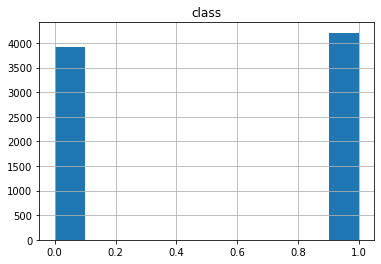

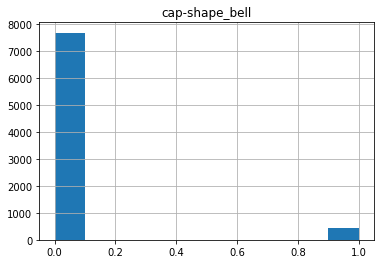

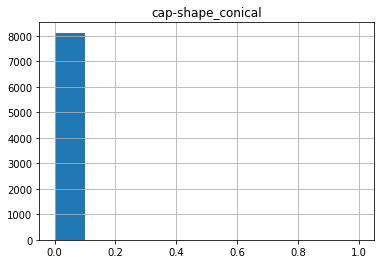

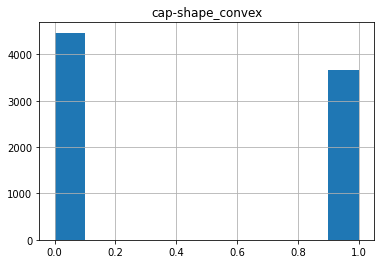

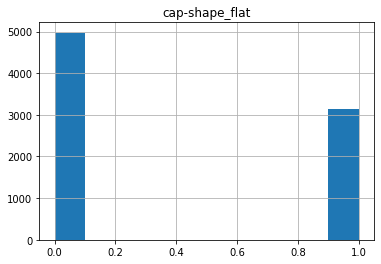

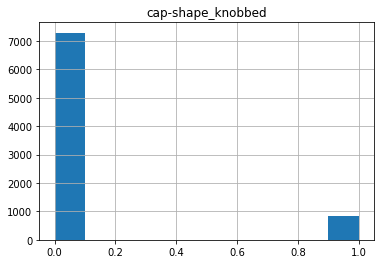

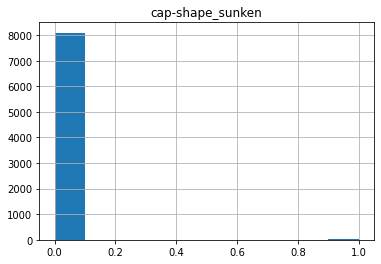

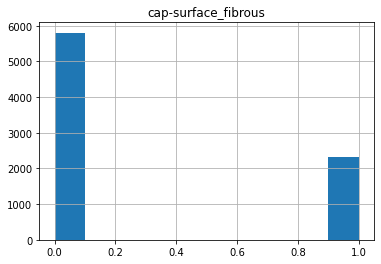

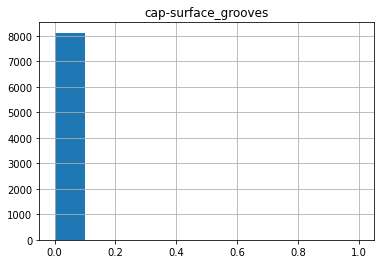

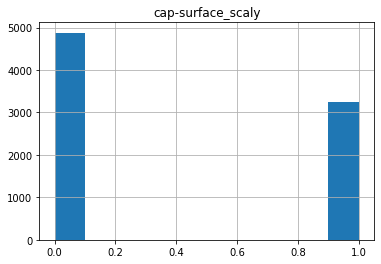

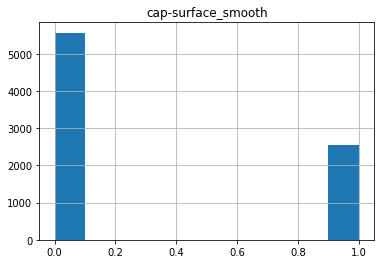

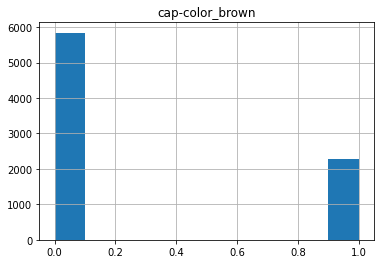

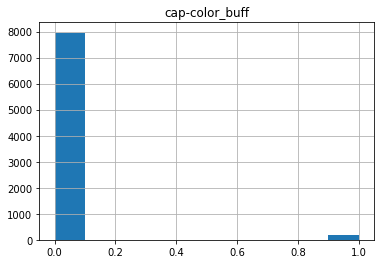

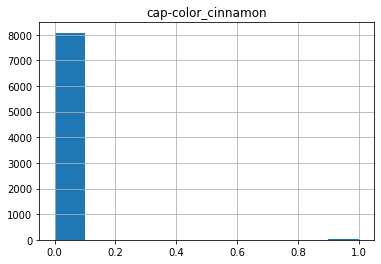

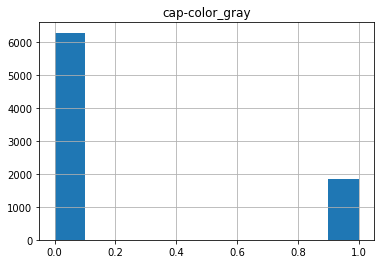

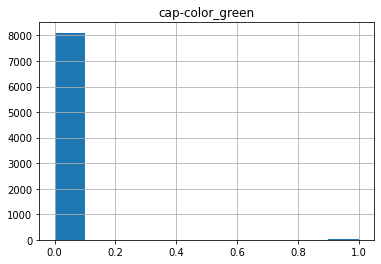

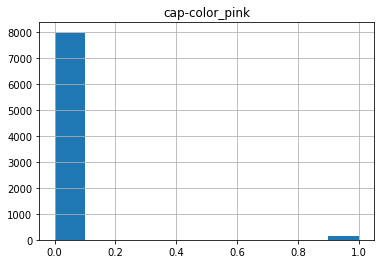

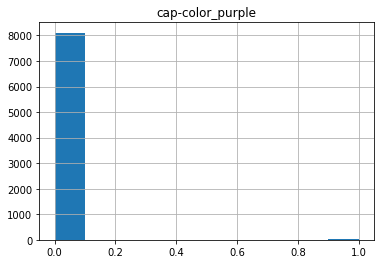

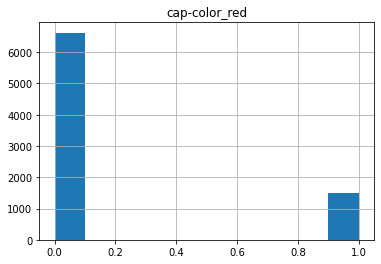

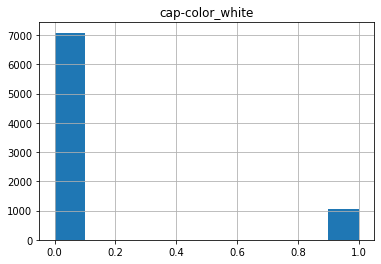

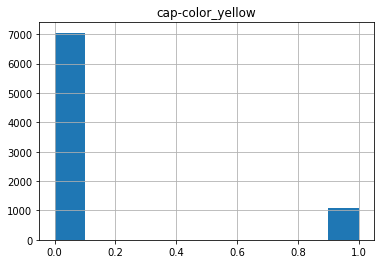

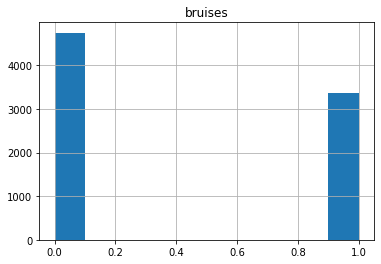

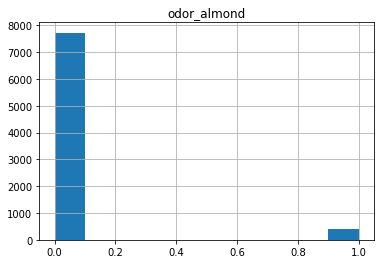

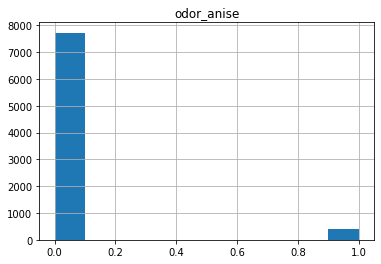

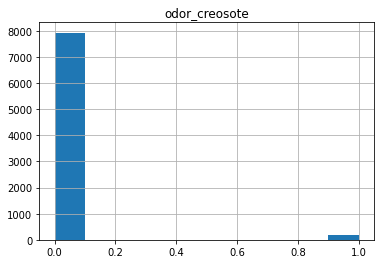

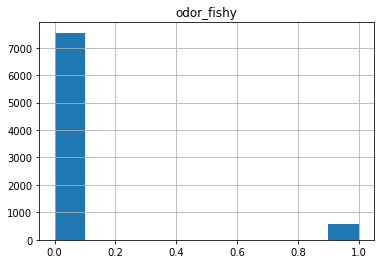

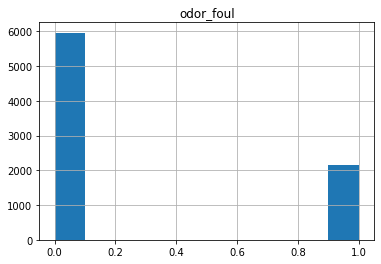

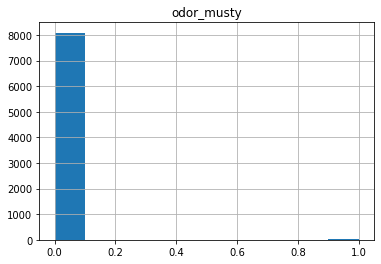

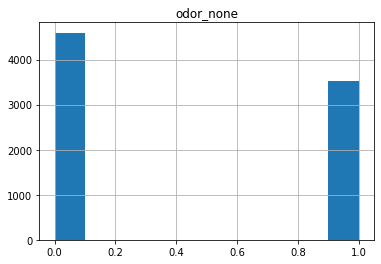

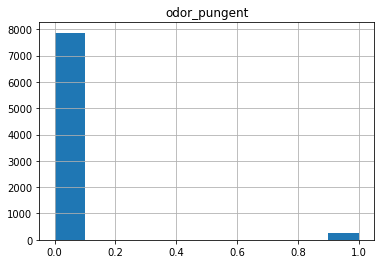

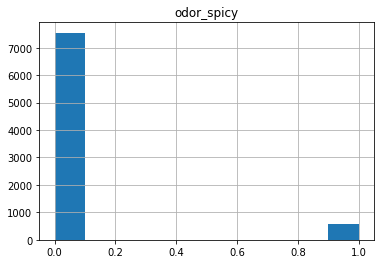

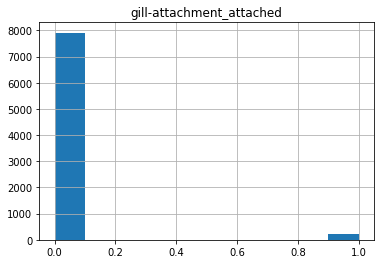

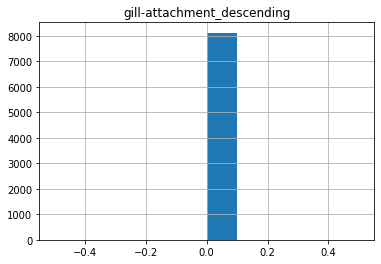

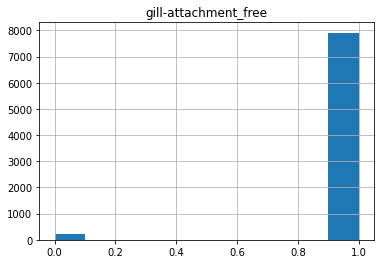

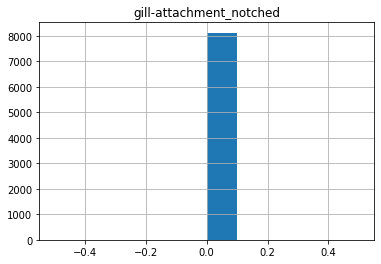

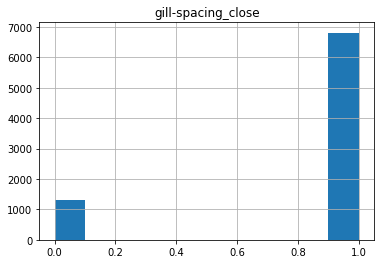

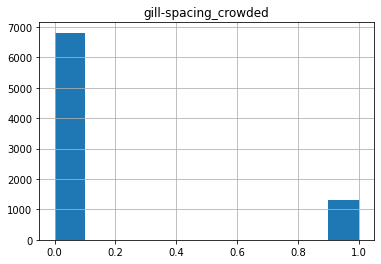

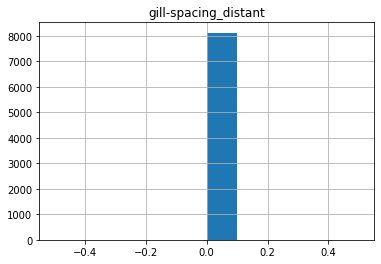

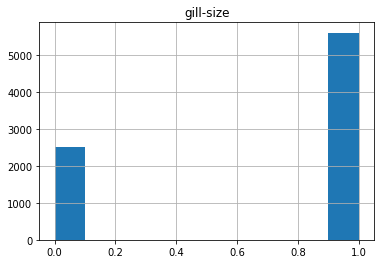

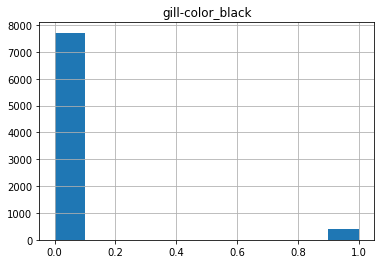

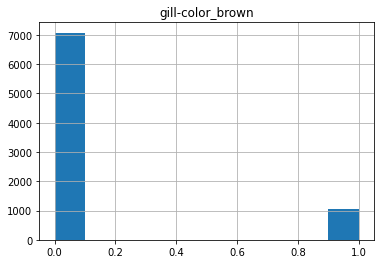

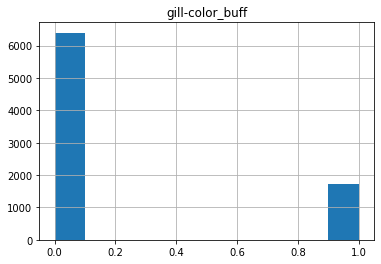

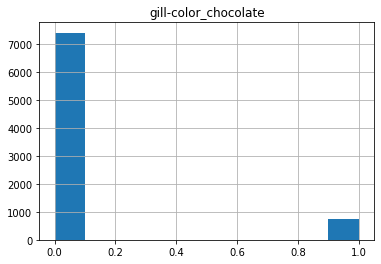

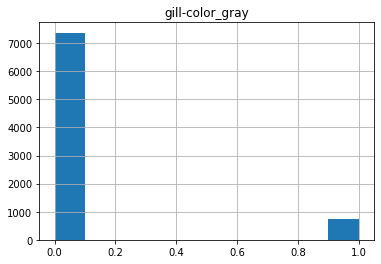

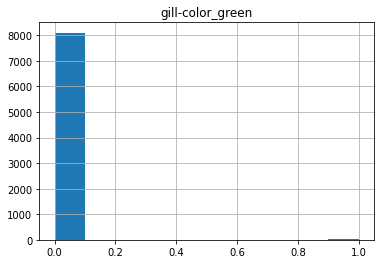

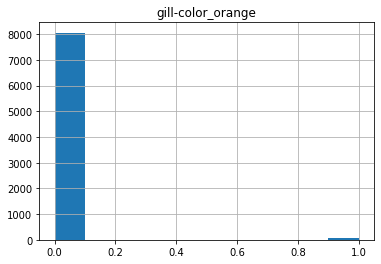

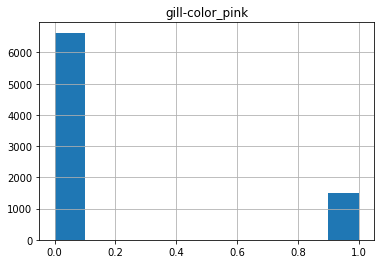

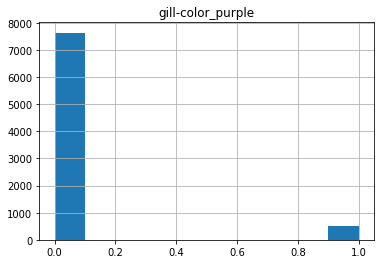

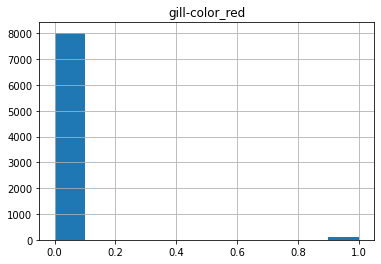

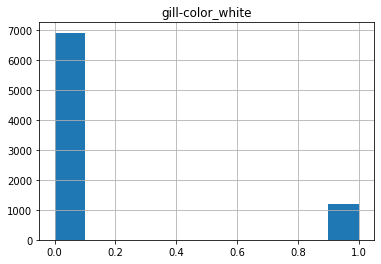

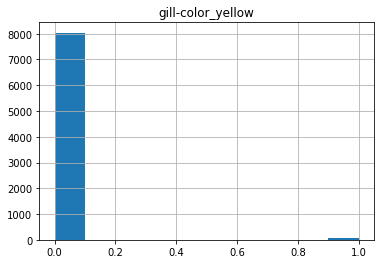

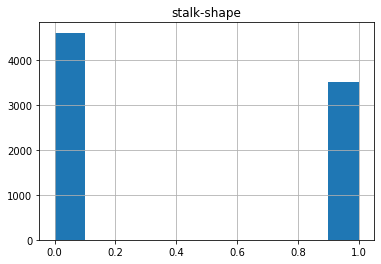

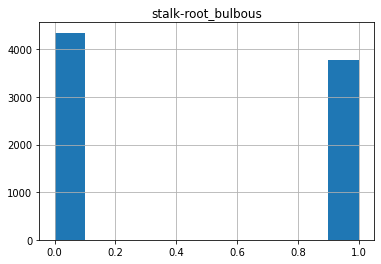

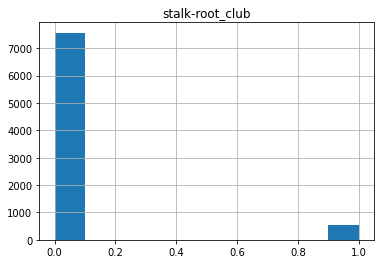

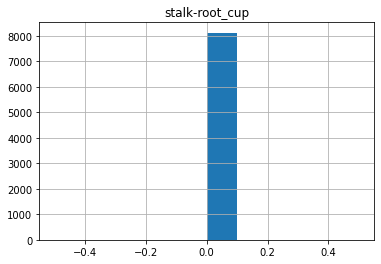

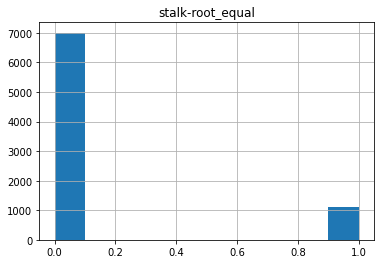

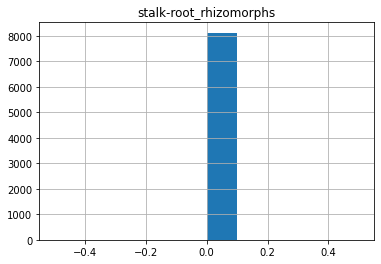

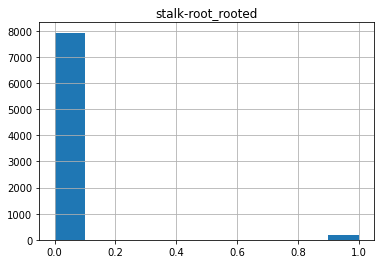

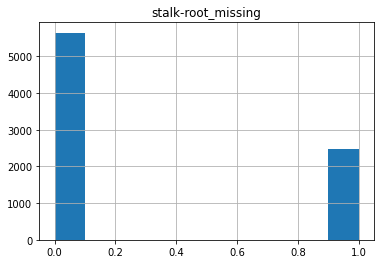

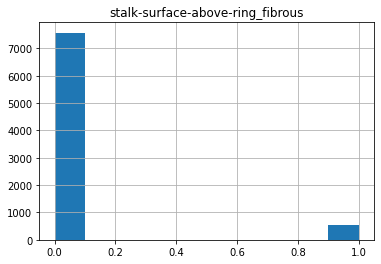

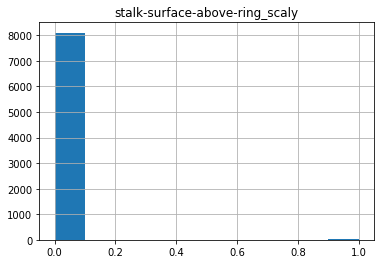

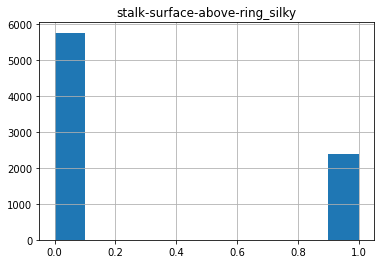

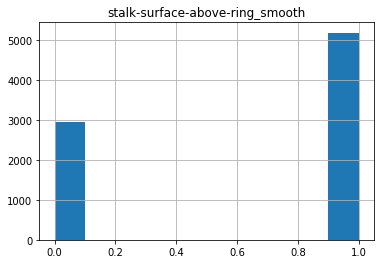

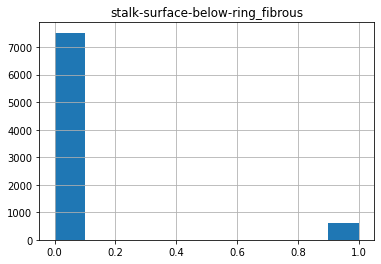

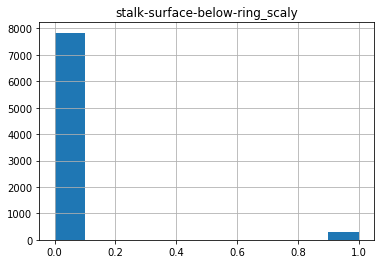

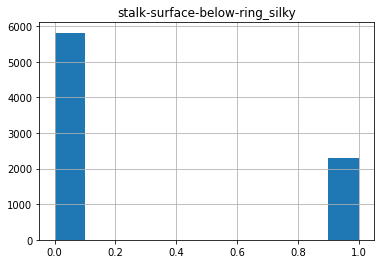

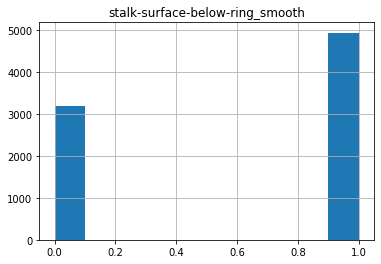

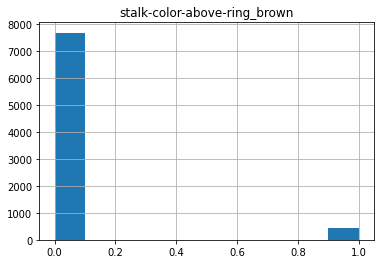

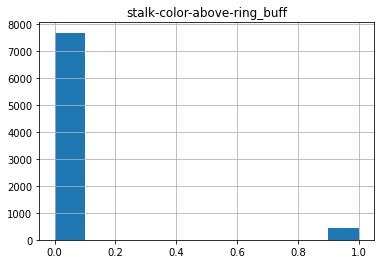

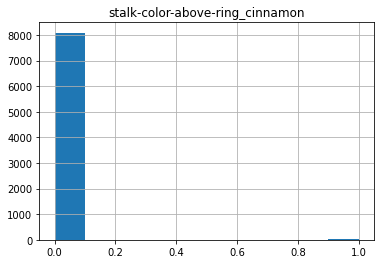

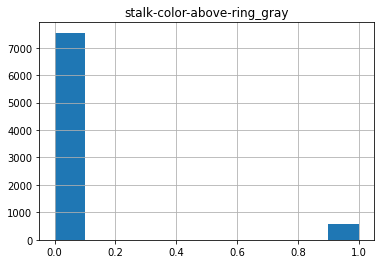

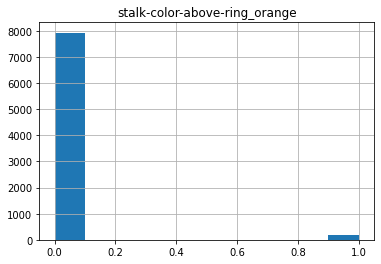

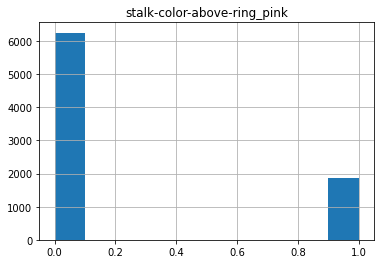

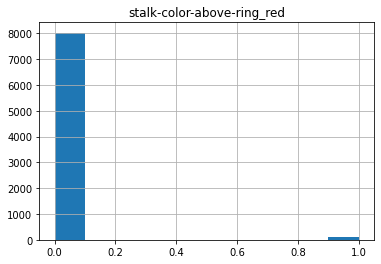

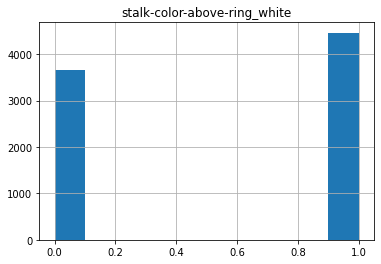

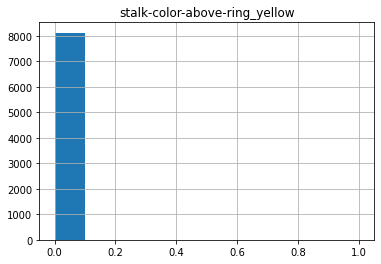

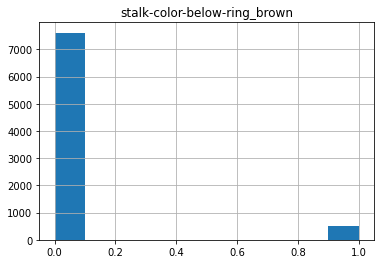

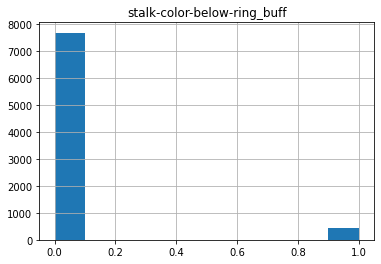

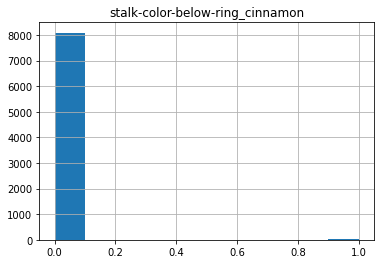

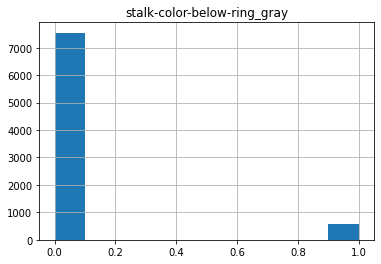

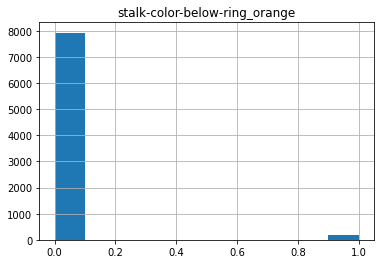

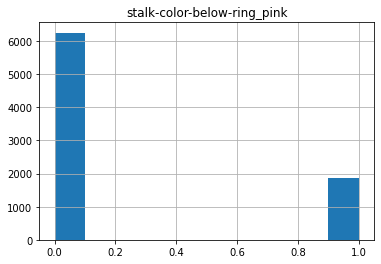

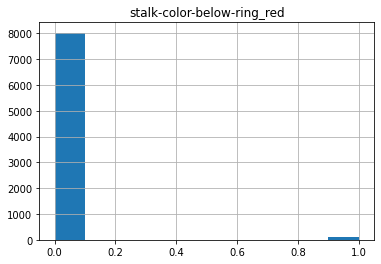

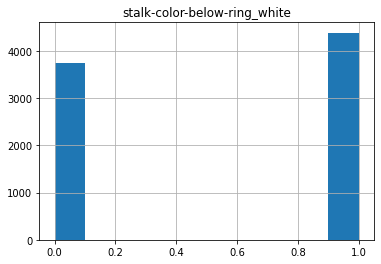

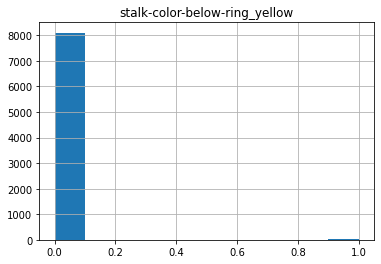

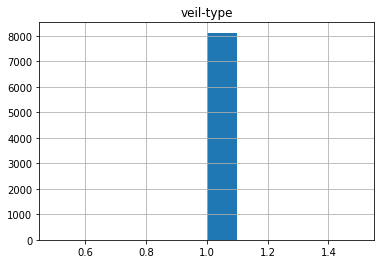

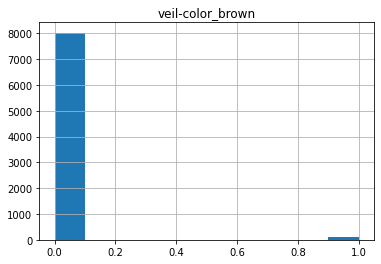

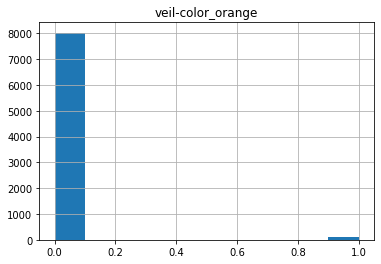

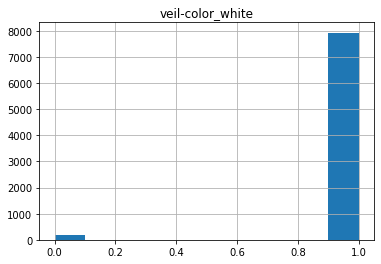

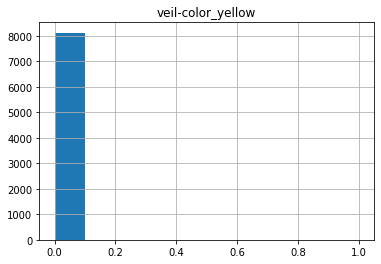

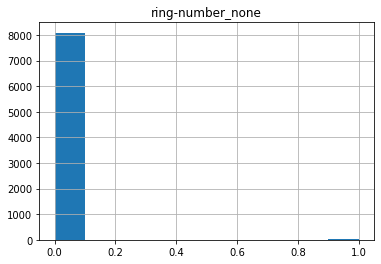

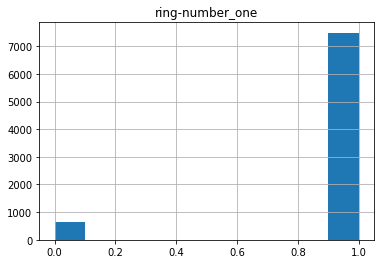

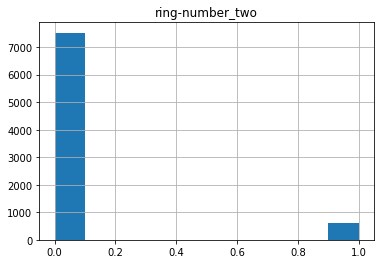

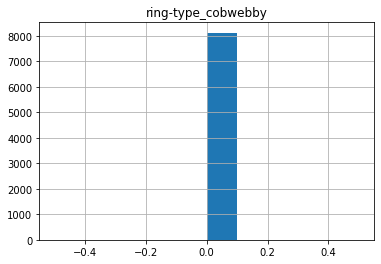

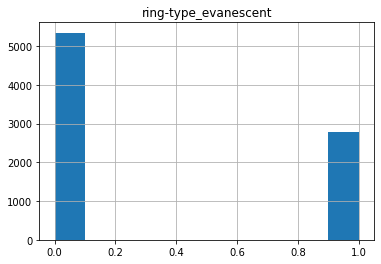

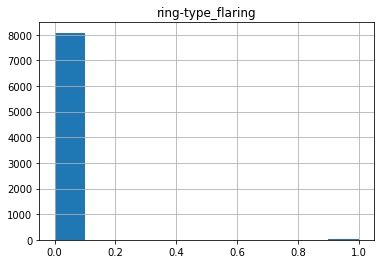

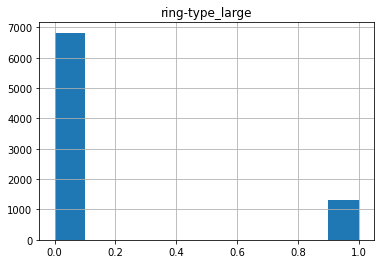

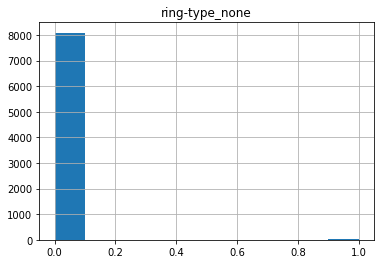

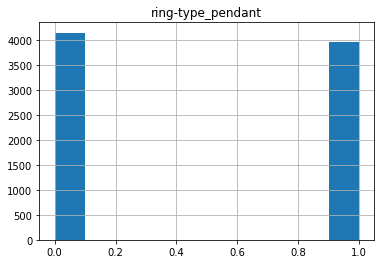

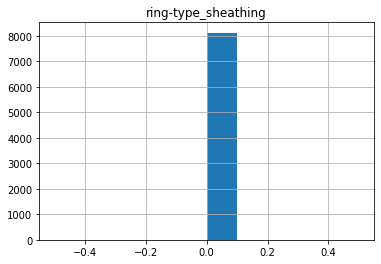

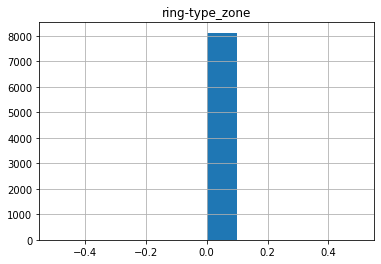

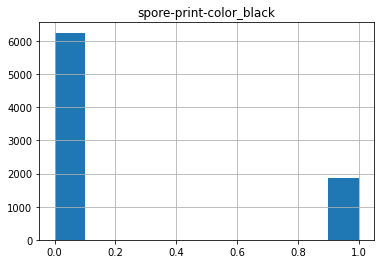

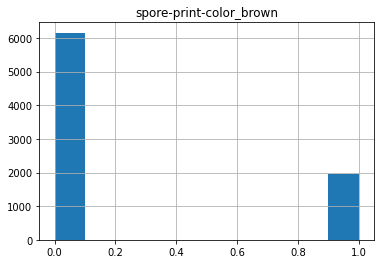

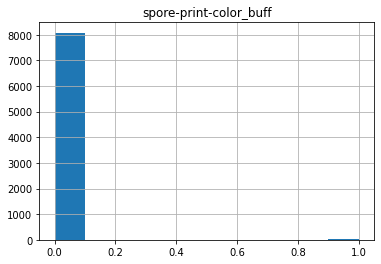

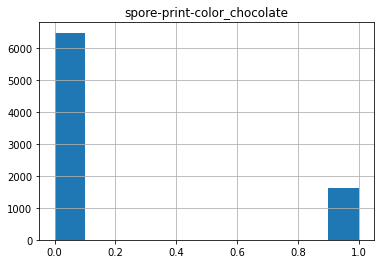

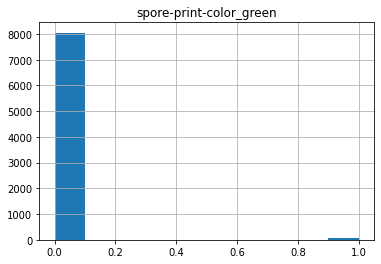

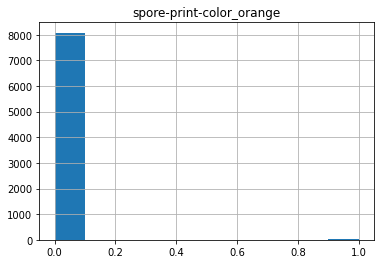

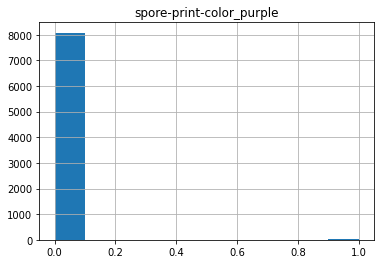

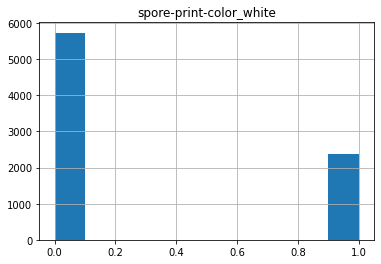

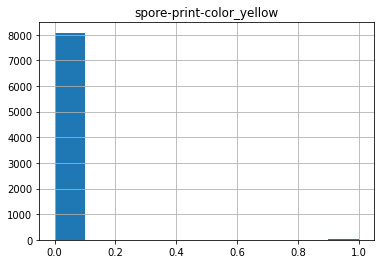

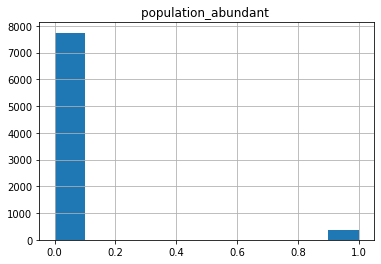

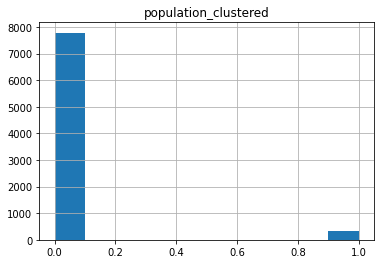

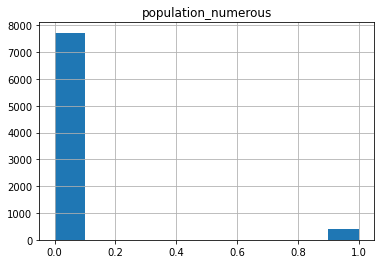

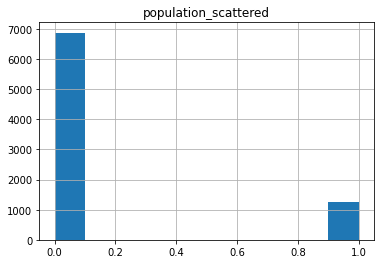

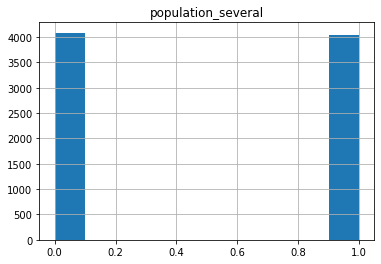

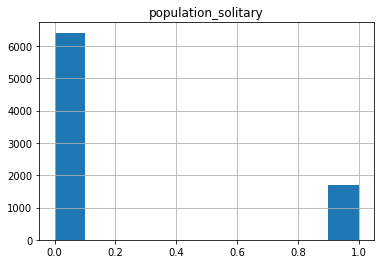

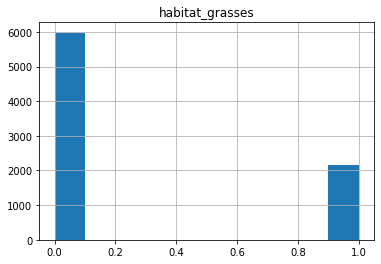

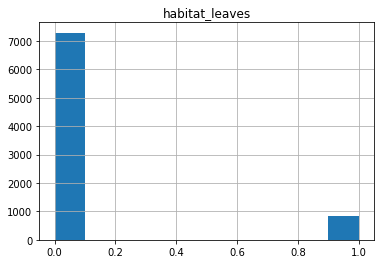

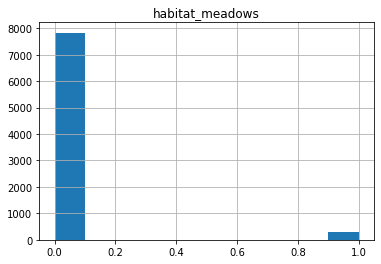

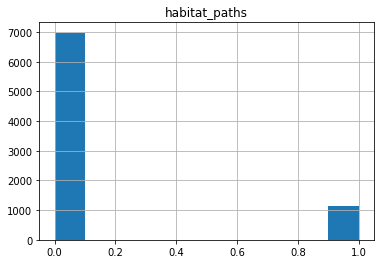

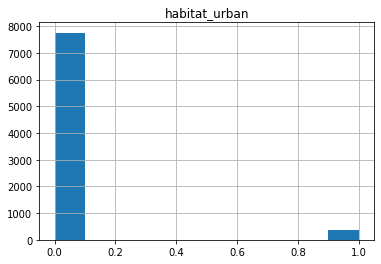

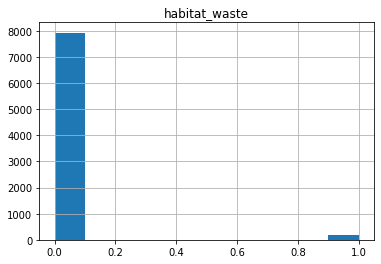

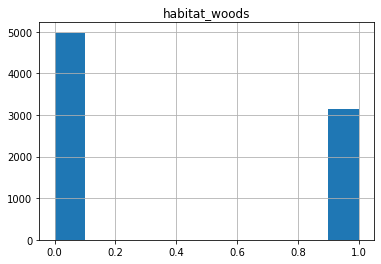

In [8]:
# Convertir spark dataset a pandas dataset
mushrooms_pd_df = mushrooms_map_df.select("*").toPandas()

for x in map_columns:
    mushrooms_pd_df.hist(x); # Se muestra el histograma de la columna x con pandas

|class|count|
|------|------|
|    1| 4208|
|    0| 3916|


De acuerdo al count de lo parametros a predecir se cuentan con cantidades similares por lo que no se requiere ajustar la cantidad de datos en este aspecto


# Normalización / Estandarización


Se crean los datos para entrenamiento y pruebas

In [9]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
features = [column for column in mushrooms_map_df.columns if column not in ['class']]

# Datos para training y test
trainingDF2, testingDF2 = mushrooms_map_df.randomSplit([0.7,0.3])

# Generar dataset con array
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')

print('Todos')
vector_df = assembler.transform(mushrooms_map_df)
vector_df.select(['features', 'class']).show()

Todos
+--------------------+-----+
|            features|class|
+--------------------+-----+
|(122,[2,9,10,20,2...|    0|
|(122,[2,9,19,20,2...|    1|
|(122,[0,9,18,20,2...|    1|
|(122,[2,8,18,20,2...|    0|
|(122,[2,9,13,27,3...|    1|
|(122,[2,8,19,20,2...|    1|
|(122,[0,9,18,20,2...|    1|
|(122,[0,8,18,20,2...|    1|
|(122,[2,8,18,20,2...|    0|
|(122,[0,9,19,20,2...|    1|
|(122,[2,8,19,20,2...|    1|
|(122,[2,8,19,20,2...|    1|
|(122,[0,9,19,20,2...|    1|
|(122,[2,8,18,20,2...|    0|
|(122,[2,6,10,27,3...|    1|
|(122,[5,6,13,27,3...|    1|
|(122,[3,6,18,27,3...|    1|
|(122,[2,9,10,20,2...|    0|
|(122,[2,8,18,20,2...|    0|
|(122,[2,9,10,20,2...|    0|
+--------------------+-----+
only showing top 20 rows



Descomentar codigo de la matrix si quiere ver la matrix que se genera con las 123 cols

In [10]:
# Matrix de correlacion

# plt.subplots(figsize=(25,20))
# pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]
# sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".5f", linewidths=0, cmap='viridis')


## Problemas de lectura de la matriz de correlacion

Dado a la gran cantidad de columnas la matriz de correlacion resulta complicada de leer en una imagen

Por lo que se utilizara una PCA para delimitar los componentes principales



## PCA

+--------------------+-----+
|         featuresPCA|class|
+--------------------+-----+
|[-1.6667827362191...|    0|
|[-1.7696577051826...|    1|
|[-1.8924611565908...|    1|
|[-1.7512538548322...|    0|
|[-1.4774420676050...|    1|
|[-1.7610274358878...|    1|
|[-1.7734524493444...|    1|
|[-1.8991702867374...|    1|
|[-1.4683129112237...|    0|
|[-1.7184801264021...|    1|
|[-1.6557776838369...|    1|
|[-1.7839581983376...|    1|
|[-1.8655773933057...|    1|
|[-1.4369590376518...|    0|
|[-1.3602254796730...|    1|
|[-1.5916060158135...|    1|
|[-1.5470811476678...|    1|
|[-1.7637202876742...|    0|
|[-1.7581333324300...|    0|
|[-1.6736622138169...|    0|
+--------------------+-----+
only showing top 20 rows



,varianza explicada
0,0.160261
1,0.135853
2,0.095698
3,0.057342
4,0.039786
5,0.038241
6,0.033085
7,0.029216
8,0.023186
9,0.022033


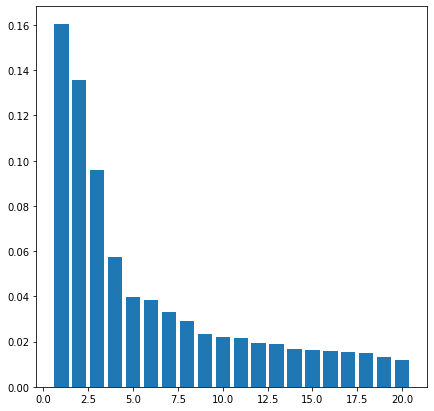

In [11]:
features = [column for column in mushrooms_map_df.columns if column not in ['class']]

# Componentes principales 
k=20
# Mejor valor 35

pcaModel = PCA(
    k=k, 
    inputCol="features", 
    outputCol="featuresPCA").fit(vector_df)

transf_pca_df = pcaModel.transform(vector_df)

transf_pca_df.select(['featuresPCA' ,'class']).show()

# Visualizacion del PCA
plt.figure(figsize=(7,7))
eigenvalues = [float(value) for value in pcaModel.explainedVariance]
plt.bar(list(range(1,len(eigenvalues)+1)),eigenvalues)
pd.DataFrame(eigenvalues,columns=['varianza explicada'])

<AxesSubplot:>

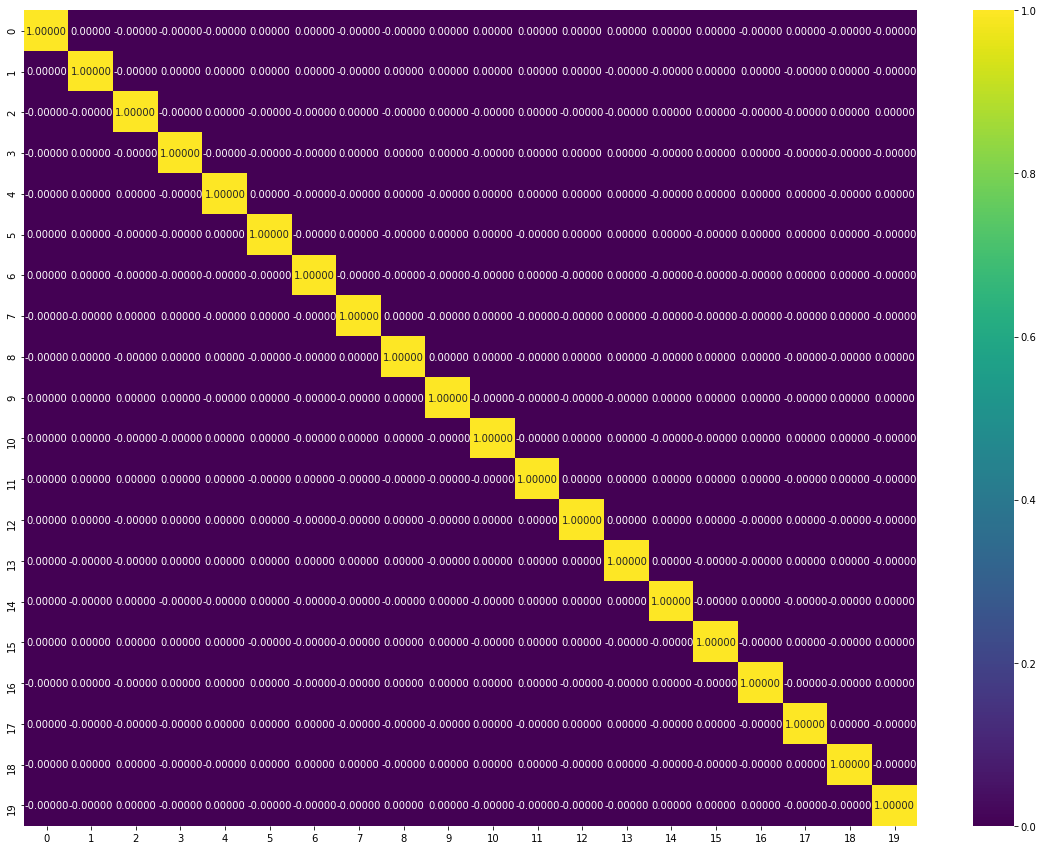

In [12]:
# Matrix de correlacion PCA
 
plt.subplots(figsize=(20,15))
pearson_matrix = Correlation.corr(transf_pca_df, 'featuresPCA').collect()[0][0]
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".5f", linewidths=0, cmap='viridis')

# Inspección de datos


In [13]:
# Cargar el conjunto de datos. Esta vez desde la base de datos
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3_mapeado") \
    .load()

In [14]:
# Información descriptiva del dataframe.

# Convertir spark dataset a pandas dataset
pd_df = df.select("*").toPandas()

features = [column for column in mushrooms_map_df.columns if column not in ['class']]

for x in features:    
    mushrooms_map_df.groupBy(x).count().show() # Se muestra el count de los campos y sus valores

+--------------+-----+
|cap-shape_bell|count|
+--------------+-----+
|             1|  452|
|             0| 7672|
+--------------+-----+

+-----------------+-----+
|cap-shape_conical|count|
+-----------------+-----+
|                1|    4|
|                0| 8120|
+-----------------+-----+

+----------------+-----+
|cap-shape_convex|count|
+----------------+-----+
|               1| 3656|
|               0| 4468|
+----------------+-----+

+--------------+-----+
|cap-shape_flat|count|
+--------------+-----+
|             1| 3152|
|             0| 4972|
+--------------+-----+

+-----------------+-----+
|cap-shape_knobbed|count|
+-----------------+-----+
|                1|  828|
|                0| 7296|
+-----------------+-----+

+----------------+-----+
|cap-shape_sunken|count|
+----------------+-----+
|               1|   32|
|               0| 8092|
+----------------+-----+

+-------------------+-----+
|cap-surface_fibrous|count|
+-------------------+-----+
|                  1| 

# Sin PCA

In [15]:
trainingDF, testingDF = vector_df.randomSplit([0.7,0.3])

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(trainingDF)

scaled_training_df = scale_model.transform(trainingDF)
scaled_testing_df = scale_model.transform(testingDF)

print('Datos de entrenamiento - total elementos', trainingDF.count())
# scaled_training_df.select(['features','class']).show()

print('Datos de prueba - total elementos', testingDF.count())
# scaled_testing_df.select(['features','class']).show()


Datos de entrenamiento - total elementos 5701
Datos de prueba - total elementos 2423


## Binomial Logistic Regression

In [16]:
# se entrena el modelo 
logistic_regression = LogisticRegression(featuresCol='scaled', labelCol='class', maxIter=5)
logistic_regression_model = logistic_regression.fit(scaled_training_df)

print("Pesos: " + str(logistic_regression_model.coefficients))
print("b: " + str(logistic_regression_model.intercept))

scaled_training_df.select(['features', 'class']).describe().show()


Pesos: [0.11208364177850447,-0.06478068158691241,-0.010199861677000028,-0.015174569137398048,-0.06479950127540131,0.09360098109790167,0.2123360577106711,-0.08098855350029731,-0.013288429256182226,-0.1931077281707646,0.07531337398040516,-0.16580990343373145,0.11601617304061466,0.06594932952670458,0.08549750265562943,-0.14285730401447433,0.09223706780109675,-0.02690329866781274,-0.02929138714786361,-0.05378568228909102,0.28627847100509635,0.207435663489103,0.2117551348774778,-0.39478321113246995,-0.20509177646540103,-0.5282995981298807,-0.06844412215954351,0.7899324766487811,-0.4421899931179889,-0.20465782728461895,0.09307241790205474,0.0,-0.10852876972753595,0.0,-0.32301729297737647,0.31635324629473055,0.0,0.5070900621647537,0.07760435932344682,0.1923220941146387,-0.3877799257171382,-0.10453621686599707,-0.07415299278261663,-0.1148052049314268,0.0645689191689465,0.041247076893865205,0.13416172136523205,0.10159900582982122,0.18457828999608764,0.02423720716897954,-0.145109783675543,-0.063

In [17]:
# Testing 
predictions = logistic_regression_model.transform(scaled_testing_df)
evaluator = BinaryClassificationEvaluator()

predictions.select(['class','prediction', 'rawPrediction', 'probability']).show(10)

accuracy = predictions.filter(predictions['class'] == predictions.prediction).count() / float(predictions.count())

print("Accuracy: ",accuracy)

+-----+----------+--------------------+--------------------+
|class|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|    0|       0.0|[5.28004728422745...|[0.99493360901878...|
|    0|       0.0|[5.77245741601900...|[0.99689755473679...|
|    0|       0.0|[6.10071512701394...|[0.99776374767506...|
|    0|       0.0|[6.83112781391727...|[0.99892152456707...|
|    0|       0.0|[7.79859503053406...|[0.99958985723740...|
|    0|       0.0|[7.64269043063059...|[0.99952069328996...|
|    0|       0.0|[7.27162933244123...|[0.99930550394058...|
|    0|       0.0|[7.10747691164461...|[0.99918171145181...|
|    0|       0.0|[7.59988704343616...|[0.99949974241699...|
|    0|       0.0|[8.00204201934456...|[0.99966533373334...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows

Accuracy:  0.9979364424267437


### K-fold cross validation

In [18]:
scaled_training_kfold_df = scaled_training_df.withColumn("label", scaled_training_df["class"])
scaled_testing_kfold_df = scaled_testing_df.withColumn("label", scaled_testing_df["class"])

grid = ParamGridBuilder().addGrid(logistic_regression.maxIter, [0, 1, 5]).build()

cv = CrossValidator(estimator=logistic_regression, estimatorParamMaps=grid, evaluator=evaluator, parallelism=4, numFolds=3)

cvModel = cv.fit(scaled_training_kfold_df)
cvPredictions = cvModel.transform(scaled_testing_kfold_df)

accuracy = cvPredictions.filter(predictions['class'] == cvPredictions.prediction).count() / float(cvPredictions.count())

print("Accuracy: ",accuracy)

Accuracy:  0.9979364424267437


### Guardar en base de datos modelo 1

In [19]:
temp_df_modelo1 = cvPredictions.withColumnRenamed("prediction","prediccion")

modelo1 = temp_df_modelo1.select(map_columns_prediction)
modelo1 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

## Naive Bayes

In [20]:
# Entrenamiento

# Se renombran las colummas 
scaled_training_df_temp = scaled_training_df.withColumnRenamed("class","label")

# se entrena el modelo 
naive_bayes = NaiveBayes(smoothing=1.0, modelType="multinomial")
naive_bayes_model = naive_bayes.fit(scaled_training_df_temp)

scaled_training_df_temp.select(['features', 'label']).describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|              5701|
|   mean|0.5100859498333625|
| stddev|0.4999421120673343|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [21]:
# Testing
predictions = naive_bayes_model.transform(scaled_testing_df)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ",accuracy)

Accuracy:  0.9467602146099876


### K-fold cross validation

In [22]:
scaled_training_kfold_df = scaled_training_df.withColumn("label", scaled_training_df["class"])
scaled_testing_kfold_df = scaled_testing_df.withColumn("label", scaled_testing_df["class"])

grid = ParamGridBuilder().addGrid(naive_bayes.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).build()

cv = CrossValidator(estimator=naive_bayes, estimatorParamMaps=grid, evaluator=evaluator, parallelism=4, numFolds=5)

# Training
cvModel = cv.fit(scaled_training_kfold_df)

# Testing
cvPredictions = cvModel.transform(scaled_testing_kfold_df)

accuracy = cvPredictions.filter(predictions['class'] == cvPredictions.prediction).count() / float(cvPredictions.count())

print("Accuracy: ",accuracy)

Accuracy:  0.998349153941395


### Guardar en base de datos modelo 1

In [23]:
temp_df_modelo2 = cvPredictions.withColumnRenamed("prediction","prediccion")

modelo2 = temp_df_modelo2.select(map_columns_prediction)
modelo2 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()

# PCA


In [24]:
temp_df = transf_pca_df.select(['class', 'featuresPCA'])

trainingDF_pca, testingDF_pca = temp_df.randomSplit([0.7,0.3])

print('Training', trainingDF_pca.count())
print('Testing', testingDF_pca.count())

# Se estandarizan los datos 
standard_pca_scaler = StandardScaler(inputCol='featuresPCA', outputCol='scaled')
scale_pca_model = standard_pca_scaler.fit(trainingDF_pca)

scaled_training_pca_df = scale_pca_model.transform(trainingDF_pca)
scaled_testing_pca_df = scale_pca_model.transform(testingDF_pca)

print('Training')
scaled_training_pca_df.show()
print('Testing')
scaled_testing_pca_df.show()

Training 5658
Testing 2466
Training
+-----+--------------------+--------------------+
|class|         featuresPCA|              scaled|
+-----+--------------------+--------------------+
|    0|[-1.8568216755822...|[-1.4143560611874...|
|    0|[-1.8499421979844...|[-1.4091159075603...|
|    0|[-1.8461701906530...|[-1.4062427391230...|
|    0|[-1.8130950093196...|[-1.3810491064716...|
|    0|[-1.8062155317218...|[-1.3758089528445...|
|    0|[-1.8052957380091...|[-1.3751083385476...|
|    0|[-1.8024435243904...|[-1.3729357844072...|
|    0|[-1.8018599986926...|[-1.3724913081721...|
|    0|[-1.7981174752967...|[-1.3696405978865...|
|    0|[-1.7967313127919...|[-1.3685847467155...|
|    0|[-1.7955640467927...|[-1.3676956307801...|
|    0|[-1.7949805210948...|[-1.3672511545449...|
|    0|[-1.7946442530799...|[-1.3669950164832...|
|    0|[-1.7877647754822...|[-1.3617548628561...|
|    0|[-1.7843290361656...|[-1.3591378324805...|
|    0|[-1.7705997652720...|[-1.3486801359987...|
|    0|[-1.761

## Binomial Logistic Regression 

In [25]:
# Se entrena el modelo
logistic_regression_pca = LogisticRegression(featuresCol='scaled', labelCol='class')
logistic_regression_pca_model = logistic_regression_pca.fit(scaled_training_pca_df)

print("Pesos: " + str(logistic_regression_pca_model.coefficients))
print("b: " + str(logistic_regression_pca_model.intercept))

scaled_training_pca_df.describe().show()

Pesos: [-10.621876381829239,3.7854517568813284,0.23999064385929694,-4.410792305515361,1.1929579635613863,-1.3072380171693516,-2.4583127950896433,1.2399206501662292,-0.6209327863512205,0.175302599939171,0.6306792974931961,0.22949294132589537,0.9011883038957085,0.43183005709888456,0.9834310843404431,-0.4588898759424682,1.9691329280832268,0.8630399653385146,-1.782724764146945,0.5310439973900842]
b: 0.65558020614386
+-------+------------------+
|summary|             class|
+-------+------------------+
|  count|              5658|
|   mean|0.5171438670908448|
| stddev|0.4997501664840782|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [26]:
# testing 
predictions_pca = logistic_regression_pca_model.transform(scaled_testing_pca_df)
evaluator_pca = BinaryClassificationEvaluator()

predictions_pca.select(['class','prediction', 'rawPrediction', 'probability']).show(10)

accuracy_pca = predictions_pca.filter(predictions_pca['class'] == predictions_pca.prediction).count() / float(predictions_pca.count())

print("Accuracy: ",accuracy_pca)

+-----+----------+--------------------+--------------------+
|class|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|    0|       0.0|[4.62352598294177...|[0.99027734174477...|
|    0|       0.0|[3.90630349642021...|[0.98028190596708...|
|    0|       0.0|[2.09959862372281...|[0.89086416103427...|
|    0|       1.0|[-0.6773054934918...|[0.33686295361180...|
|    0|       0.0|[4.41531594339035...|[0.98805370592417...|
|    0|       0.0|[3.92589413849838...|[0.98065703756233...|
|    0|       1.0|[-0.7067619813852...|[0.33031471830732...|
|    0|       0.0|[2.21890076250981...|[0.90193401213835...|
|    0|       0.0|[6.74777313066150...|[0.99882788554246...|
|    0|       0.0|[4.94106825796410...|[0.99290375706434...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows

Accuracy:  0.9793187347931873


### K-fold cross validation

In [27]:
scaled_training_kfold_pca_df = scaled_training_df.withColumn("label", scaled_training_pca_df["class"])
scaled_testing_kfold_pca_df = scaled_testing_df.withColumn("label", scaled_testing_pca_df["class"])

grid = ParamGridBuilder().addGrid(logistic_regression_pca_model.maxIter, [0, 1, 5]).build()

cv = CrossValidator(estimator=logistic_regression_pca, estimatorParamMaps=grid, evaluator=evaluator, parallelism=4, numFolds=5)

cvModel = cv.fit(scaled_training_kfold_pca_df)
cvPredictions = cvModel.transform(scaled_testing_kfold_pca_df)

accuracy = cvPredictions.filter(predictions['class'] == cvPredictions.prediction).count() / float(cvPredictions.count())

print("Accuracy: ",accuracy)

Accuracy:  0.9979364424267437
